## Credit Score Classification

Dataset Source: https://www.kaggle.com/datasets/parisrohan/credit-score-classification

#### Install Necessary Libraries

In [1]:
%pip install -U matplotlib
%pip install -U numpy
%pip install auto-sklearn seaborn sklearn imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Import Necessary Libraries

In [2]:
import os, sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import autosklearn
from autosklearn.classification import AutoSklearnClassifier

#### Show Library Versions

In [3]:
n = 18

print(f"Language/Library".rjust(n-2), '|', 'Version')
print('-' * (n-2), '|', '--------')
print("Python :".rjust(n), sys.version[0:6])
print("NumPy :".rjust(n), np.__version__)
print("Pandas :".rjust(n), pd.__version__)
print("Sklearn :".rjust(n), sklearn.__version__)
print("Auto-Sklearn :".rjust(n), autosklearn.__version__)
print("Seaborn :".rjust(n), sns.__version__)

Language/Library | Version
---------------- | --------
          Python : 3.10.1
           NumPy : 1.25.0
          Pandas : 1.5.3
         Sklearn : 0.24.2
    Auto-Sklearn : 0.15.0
         Seaborn : 0.12.2


### Initial Data Preprocessing

#### Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Ingest Dataset

In [5]:
col_names = ['ID',
             "customer_id",
             "month",
             "name",
             "age",
             "ssn",
             "occupation",
             "annual_income",
             "monthly_inhand_salary",
             "num_bank_accounts",
             "num_credit_card",
             "interest_rate",
             "num_loans",
             "loan_type",
             "delay_from_due_date",
             "num_delayed_payments",
             "changed_credit_limit",
             "num_credit_inquiries",
             "credit_mix",
             "outstanding_debt",
             "credit_util_ratio",
             "credit_history_age",
             "payment_of_min_amount",
             "total_emi_per_month",
             "amount_invested_monthly",
             "payment_behaviour",
             "monthly_balance",
             "label"]

dtypes = {"ID": str,
          "customer_id": str,
          "month": 'category',
          "name": str,
          "age": str,
          "ssn": str,
          "occupation": 'category',
          "annual_income": str,
          "monthly_inhand_salary": np.float32,
          "num_bank_accounts": np.uint16,
          "num_credit_card": np.uint16,
          "interest_rate": np.uint16,
          "num_loans": str,
          "loan_type": 'category',
          "delay_from_due_date": np.int8,
          "num_delayed_payments": 'category',
          "changed_credit_limit": str,
          "num_credit_inquiries": np.float32,
          "credit_mix": 'category',
          "outstanding_debt": str,
          "credit_util_ratio": np.float64,
          "credit_history_age": 'category',
          "payment_of_min_amount": 'category',
          "total_emi_per_month": np.float64,
          "amount_invested_monthly": str,
          "payment_behaviour": 'category',
          "monthly_balance": 'category',
          "label": 'category'}

data = pd.read_csv("/content/drive/MyDrive/Credit Score Classification/data/train.csv",
                   names=col_names,
                   dtype=dtypes,
                   engine='c',
                   header=0)

# drop 'ID', 'name', 'ssn', 'customer_id'
data = data.drop(columns=["ID",
                          'name',
                          'ssn',
                          'customer_id'])

# for the occupation feature, make sure to replace the '___' with 'unknown'
data['occupation'] = data['occupation'].replace({"_______": "unknown"})

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   month                    100000 non-null  category
 1   age                      100000 non-null  object  
 2   occupation               100000 non-null  category
 3   annual_income            100000 non-null  object  
 4   monthly_inhand_salary    84998 non-null   float32 
 5   num_bank_accounts        100000 non-null  uint16  
 6   num_credit_card          100000 non-null  uint16  
 7   interest_rate            100000 non-null  uint16  
 8   num_loans                100000 non-null  object  
 9   loan_type                88592 non-null   category
 10  delay_from_due_date      100000 non-null  int8    
 11  num_delayed_payments     92998 non-null   category
 12  changed_credit_limit     100000 non-null  object  
 13  num_credit_inquiries     98035 non-null   flo

#### More Data Preprocessing

In [6]:
'''
Rework the credit history length feature.
Convert the credit history length:
from -> 22 Years and 1 Months
to -> 22.083.
'''
data['credit_history_length_yrs'] = data['credit_history_age'].apply(lambda x: x.split(" Years and ")[0]).astype(np.float32)
data['credit_history_length_months'] = data['credit_history_age'].apply(lambda x: x.split(" Years and ")[-1].split(" Months")[0]).astype(np.float32)
data['credit_history_length'] = round(data['credit_history_length_yrs'] + (data['credit_history_length_months']/12),3)
data = data.drop(columns=['credit_history_length_yrs', 'credit_history_length_months', 'credit_history_age'])

# Remove leading and trailing underscores
cols_to_remove_underscores = [x for x in data.select_dtypes('object') if x != 'loan_type']

for c2ru in cols_to_remove_underscores:
    data[c2ru] = data[c2ru].astype(str).str.strip("'")
    data[c2ru] = data[c2ru].astype(str).str.strip("_")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   month                    100000 non-null  category
 1   age                      100000 non-null  object  
 2   occupation               100000 non-null  category
 3   annual_income            100000 non-null  object  
 4   monthly_inhand_salary    84998 non-null   float32 
 5   num_bank_accounts        100000 non-null  uint16  
 6   num_credit_card          100000 non-null  uint16  
 7   interest_rate            100000 non-null  uint16  
 8   num_loans                100000 non-null  object  
 9   loan_type                88592 non-null   category
 10  delay_from_due_date      100000 non-null  int8    
 11  num_delayed_payments     92998 non-null   category
 12  changed_credit_limit     100000 non-null  object  
 13  num_credit_inquiries     98035 non-null   flo

In [7]:
# Remove leading and trailing underscores
cols_to_remove_underscores = [x for x in data.select_dtypes('object') if x != 'loan_type']
cols_to_remove_underscores
for c2ru in cols_to_remove_underscores:
    data[c2ru] = data[c2ru].astype(str).str.strip("'")
    data[c2ru] = data[c2ru].astype(str).str.strip("_")

#age, annual_income, outstanding_debt, num_of_loan, monthly_balance, amount_invested_monthly
data['age'] = data['age'].str.strip('_').astype(np.int16)
data['annual_income'] = data['annual_income'].str.strip('_').astype(np.float32)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   month                    100000 non-null  category
 1   age                      100000 non-null  int16   
 2   occupation               100000 non-null  category
 3   annual_income            100000 non-null  float32 
 4   monthly_inhand_salary    84998 non-null   float32 
 5   num_bank_accounts        100000 non-null  uint16  
 6   num_credit_card          100000 non-null  uint16  
 7   interest_rate            100000 non-null  uint16  
 8   num_loans                100000 non-null  object  
 9   loan_type                88592 non-null   category
 10  delay_from_due_date      100000 non-null  int8    
 11  num_delayed_payments     92998 non-null   category
 12  changed_credit_limit     100000 non-null  object  
 13  num_credit_inquiries     98035 non-null   flo

#### Handling Large Interest Rates

In [8]:
"""
Since some of the interest rates are absurdly large numbers and the
largest legal interest rate in USA is 24% per year, I am going to
divide any value between 24 & 2400 by 100 as it is most likely in
terms of basis points. For values over 2400, I am going to divide
by 1,000. Because I do not have a subject matter expert to follow
up with about this matter, I am using my best judgment for this
update. If this was the "real world" I would follow up with the
expert/contact to make sure that I update this feature appropriately.
"""


data['interest_rate'] = data['interest_rate'].apply(lambda x: x/1000 if x > 2400 else
                                                    (x/100 if x > 24 else x))

#### More Data Preprocessing

In [9]:
# Remove negatives from values
data['num_delayed_payments'] = data['num_delayed_payments']\
    .astype(str).str.strip("'")
data['num_delayed_payments'] = data['num_delayed_payments']\
    .astype(str).str.strip("_")

data['num_delayed_payments'] = data['num_delayed_payments']\
    .astype(str).astype(np.float32)
data['num_delayed_payments'] = data['num_delayed_payments'].abs()

data['changed_credit_limit'] = data['changed_credit_limit'].astype(str).str.strip("_")
data['changed_credit_limit'] = data['changed_credit_limit'].replace({'': 0})


# Convert Data types for cleaned up columns
dtype_conversion_dict = {"age": np.uint8,
                         "annual_income": np.float32,
                         "num_loans": np.uint8,
                         "outstanding_debt": np.float32,
                         "changed_credit_limit": np.float32,
                         "amount_invested_monthly": np.float64}

data = data.astype(dtype_conversion_dict)

# Convert ages that are negative values to np.nan
data['age'] = data['age'].apply(lambda x: np.nan if x < 0 else x)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   month                    100000 non-null  category
 1   age                      100000 non-null  int64   
 2   occupation               100000 non-null  category
 3   annual_income            100000 non-null  float32 
 4   monthly_inhand_salary    84998 non-null   float32 
 5   num_bank_accounts        100000 non-null  uint16  
 6   num_credit_card          100000 non-null  uint16  
 7   interest_rate            100000 non-null  float64 
 8   num_loans                100000 non-null  uint8   
 9   loan_type                88592 non-null   category
 10  delay_from_due_date      100000 non-null  int8    
 11  num_delayed_payments     92998 non-null   float32 
 12  changed_credit_limit     100000 non-null  float32 
 13  num_credit_inquiries     98035 non-null   flo

### Visualizations

#### Create Function to Visualize Features (Histograms)

In [10]:
def histogram_visual(feature_to_visualize: pd.Series,
                     num_of_bins: int,
                     plot_title: str,
                     x_label: str,
                     x_start: float = -1.0,
                     y_label: str = "# of Samples",
                     ):
    """
    This function returns a histogram for a feature.

    Inputs:
    - feature_to_visualize: Feature to plot in the form
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - x_start: To force the x-axis of the visual to start at
    a specified value instead of the automatically generated
    value, assign the float value here. Otherwise, the
    autogenerated start value will be used.
    - y_label: The string label value for the y label.

    Output:
    - A histogram.
    """

    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
    assert type(x_start) != 'float', \
        "The x_start value must be a float value."

    ax = feature_to_visualize.hist(grid=False,
                                   bins=num_of_bins,
                                   figsize=(18, 8))
    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    if x_start != -1:
        plt.xlim([0, (max(feature_to_visualize) + (1/num_of_bins))])

    plt.show()

#### Dataset Visualization: Age

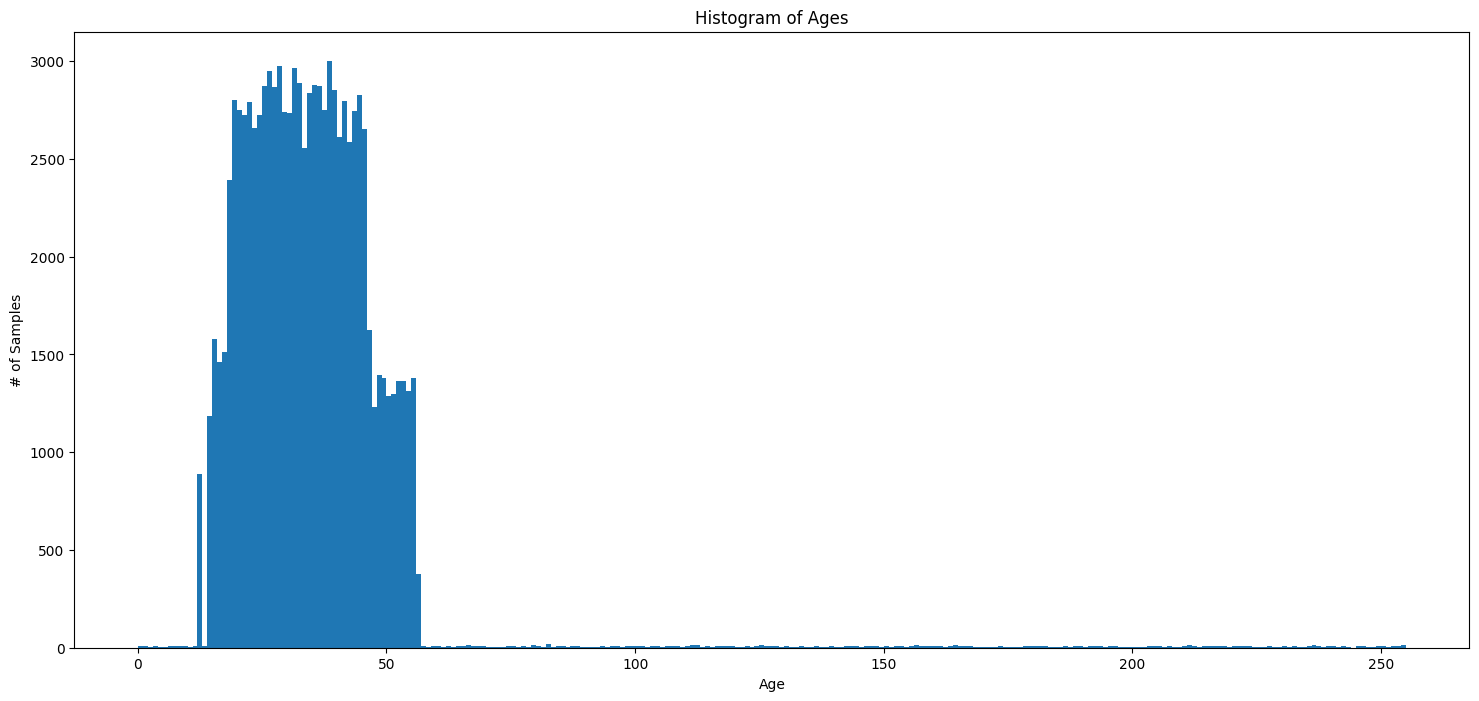

The age range is 0 to 255.


In [11]:
histogram_visual(data['age'],
                 num_of_bins=255,
                 plot_title="Histogram of Ages",
                 x_label="Age")

print(f"The age range is {min(data['age'])}" +
      f" to {max(data['age'])}.")

#### Dataset Visualization: Annual Income

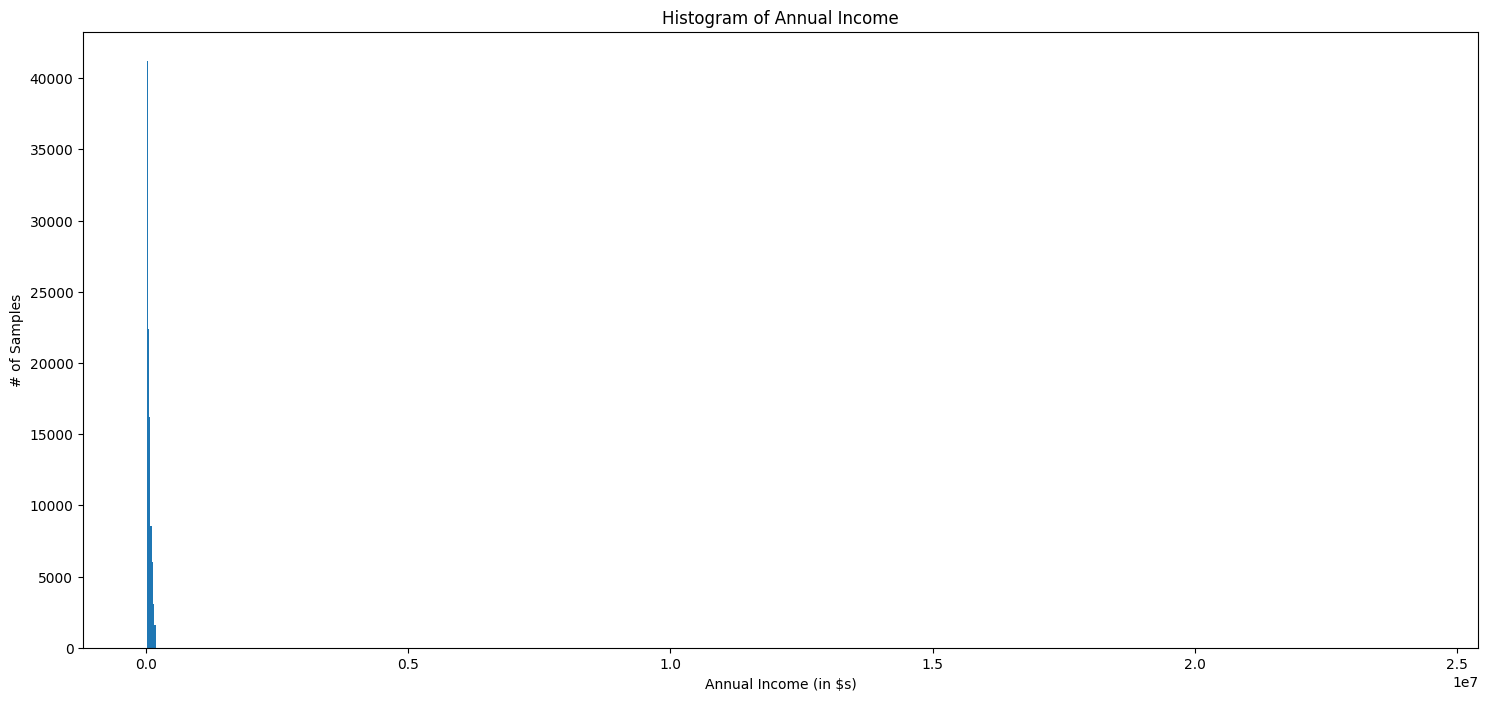

The annual income range is $7005.93 to $24198062.0 per year.


In [12]:
histogram_visual(data['annual_income'],
                 num_of_bins=970,
                 plot_title="Histogram of Annual Income",
                 x_label="Annual Income (in $s)")

print(f"The annual income range is ${round(min(data['annual_income']), 2)} to" +
      f" ${round(max(data['annual_income']), 2)} per year.")

#### Dataset Visualization: Monthly Inhand Salary

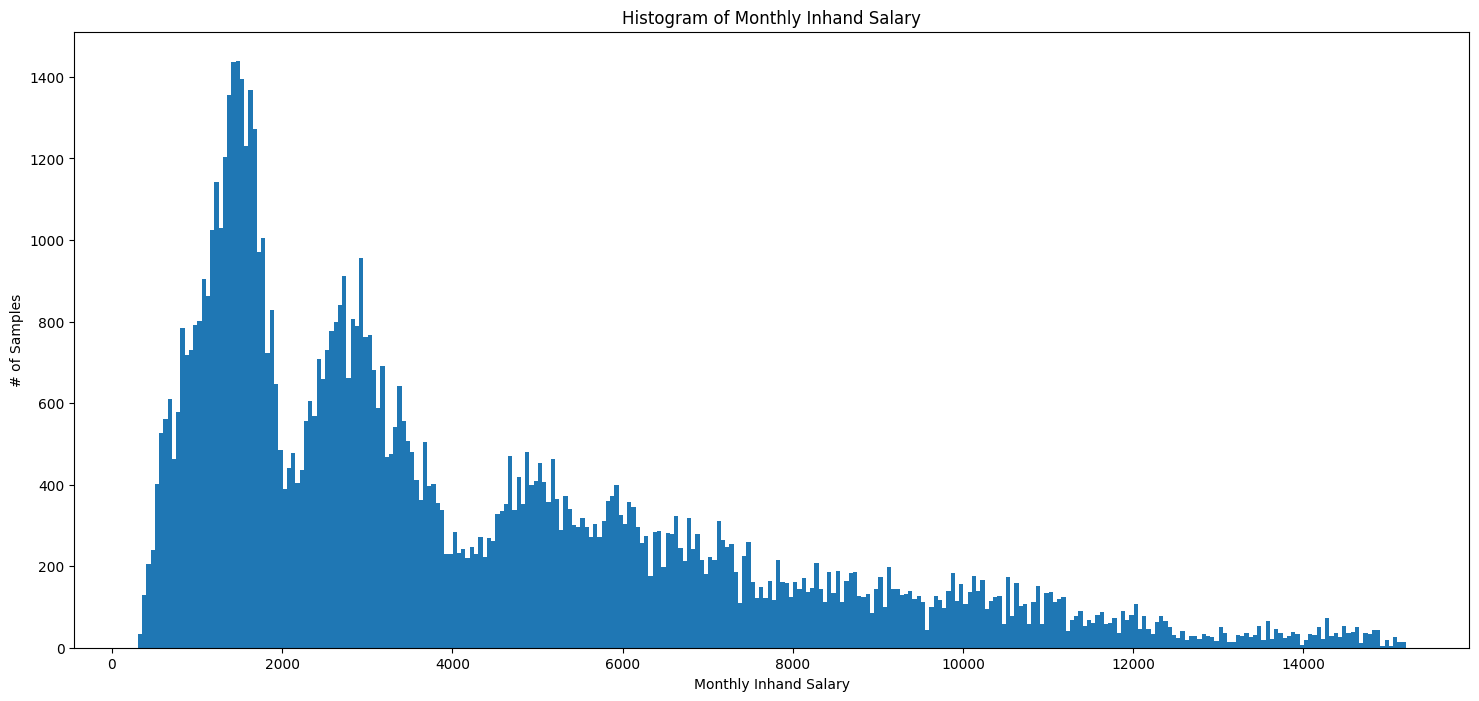

The monthly inhand salary ranges from $303.65 to $15204.63 per month.


In [13]:
histogram_visual(data['monthly_inhand_salary'],
                 num_of_bins=298,
                 plot_title="Histogram of Monthly Inhand Salary",
                 x_label="Monthly Inhand Salary")

print(f"The monthly inhand salary ranges from " +
      f"${round(min(data['monthly_inhand_salary']), 2)} to" +
      f" ${round(max(data['monthly_inhand_salary']), 2)} per month.")

#### Dataset Visualization: Number of Bank Accounts

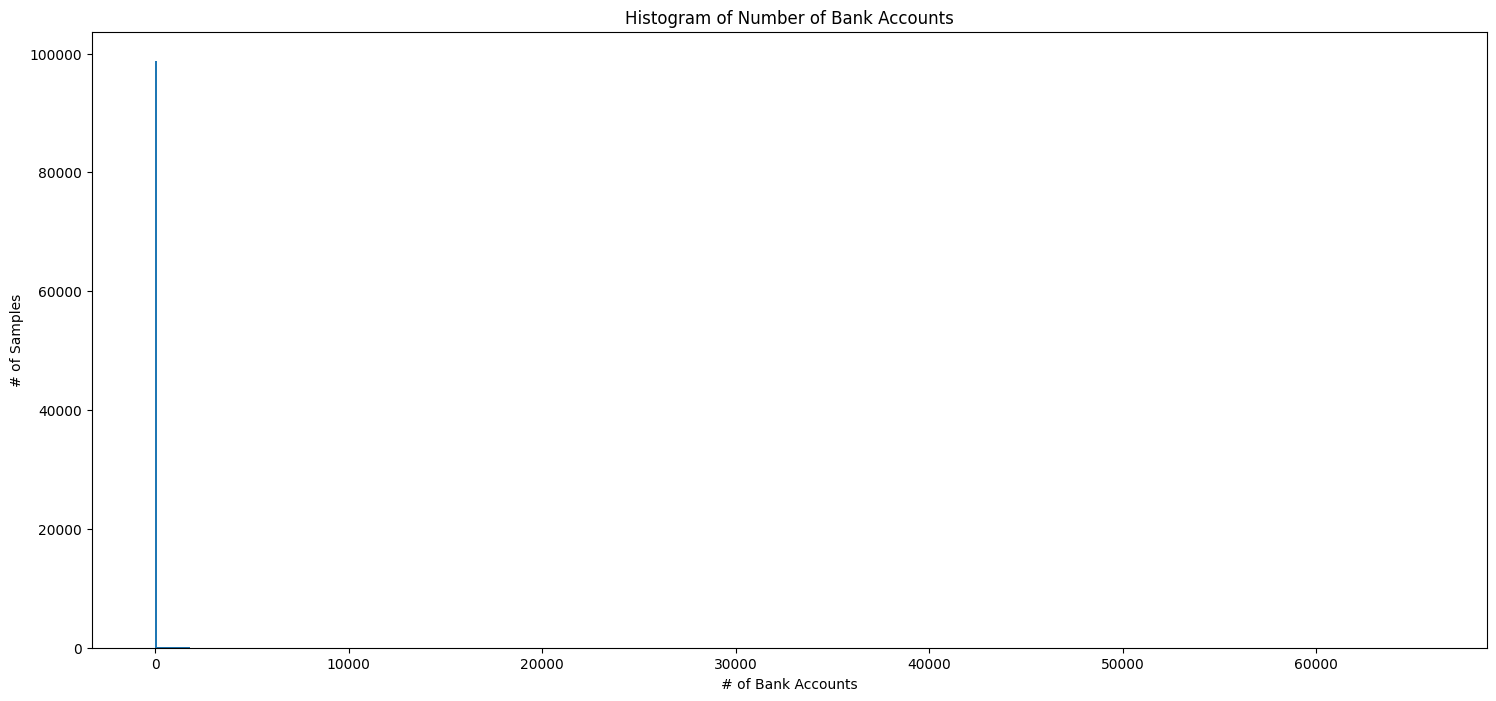

The number of bank accounts ranged from 0 to 65535.


In [14]:
histogram_visual(data['num_bank_accounts'],
                 num_of_bins=655,
                 plot_title="Histogram of Number of Bank Accounts",
                 x_label="# of Bank Accounts")

print(f"The number of bank accounts ranged" +
      f" from {min(data['num_bank_accounts'])}" +
      f" to {max(data['num_bank_accounts'])}.")

#### Dataset Visualization: Number of Credit Cards

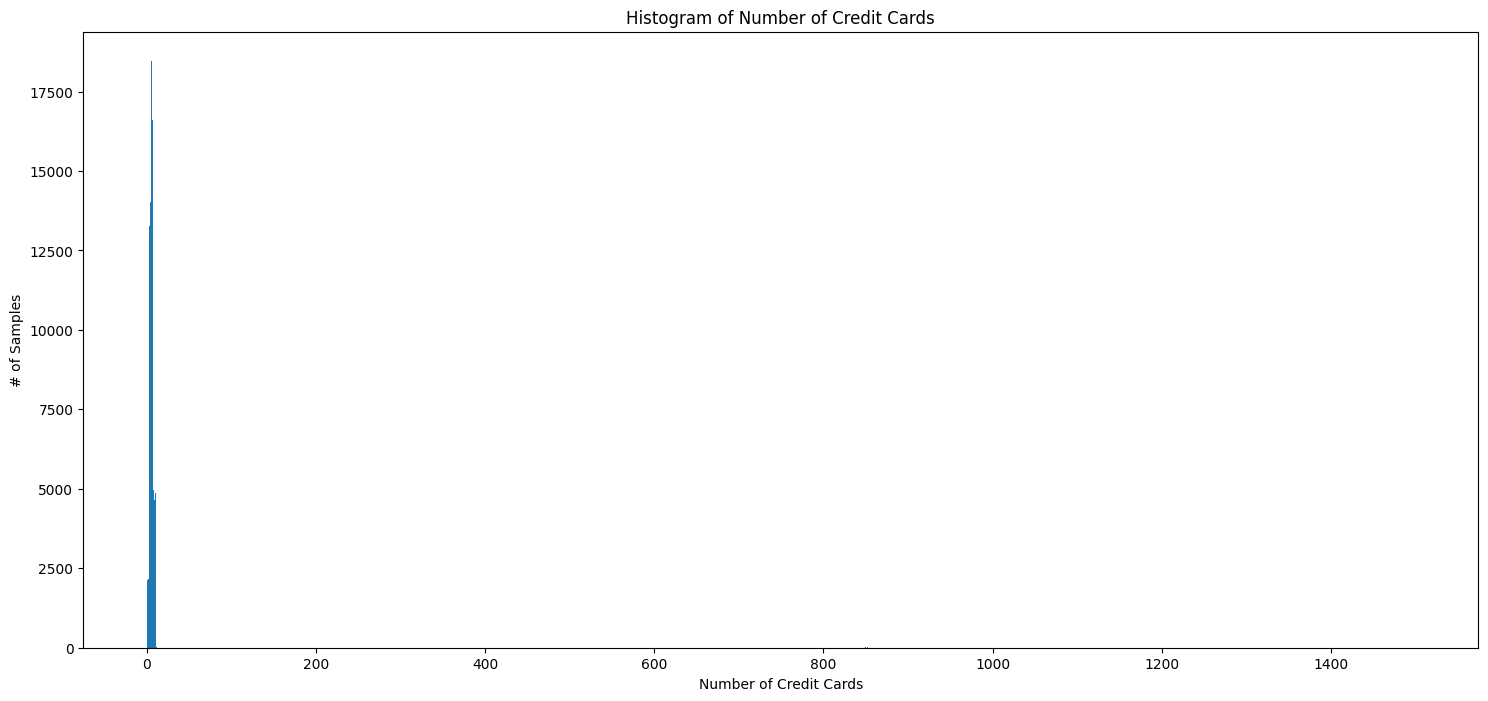

The number of credit cards ranges from 0 to 1499.


In [15]:
histogram_visual(data['num_credit_card'],
                 num_of_bins=1499,
                 plot_title="Histogram of Number of Credit Cards",
                 x_label="Number of Credit Cards")

print(f"The number of credit cards ranges from" +
      f" {min(data['num_credit_card'])} to" +
      f" {max(data['num_credit_card'])}.")

#### Dataset Visualization: Interest Rate

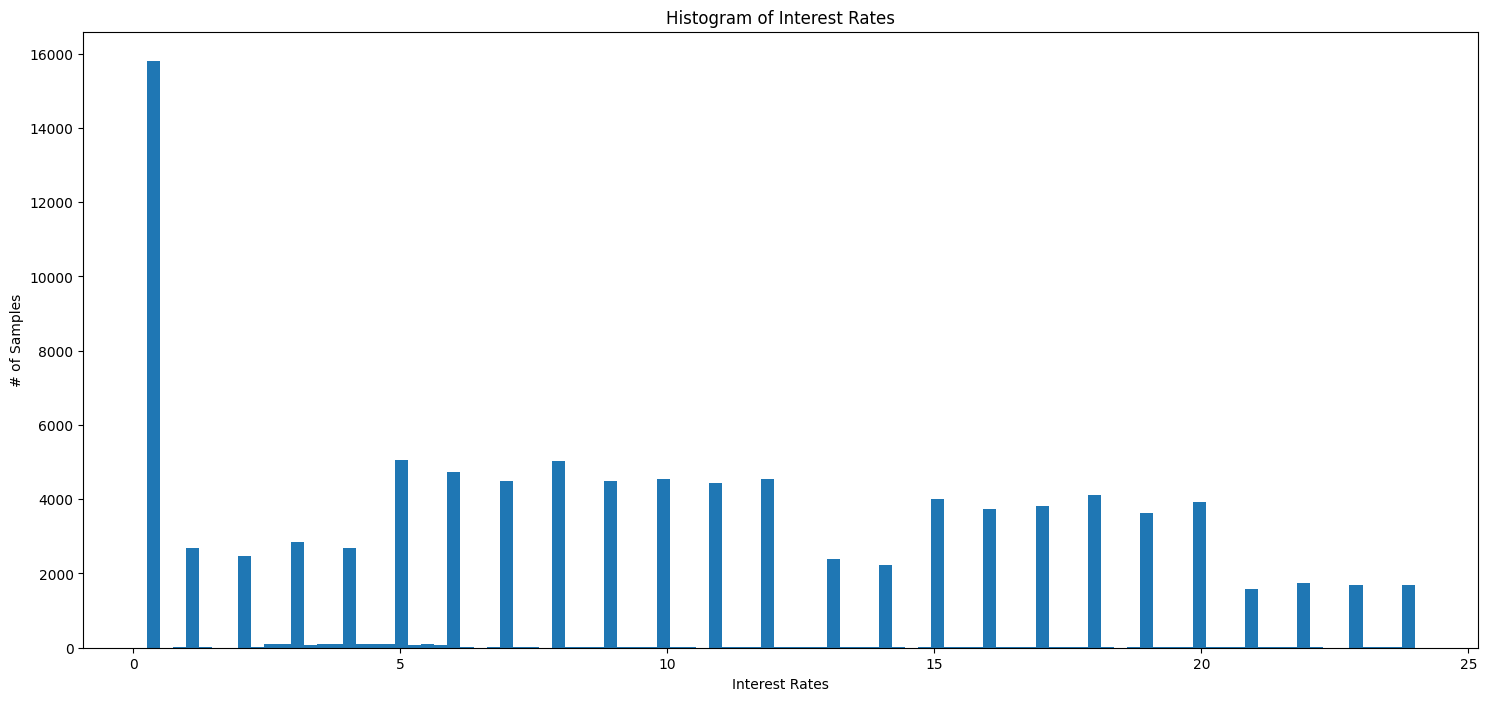

Interest rates range from 0.25 to 24.0.


In [16]:
histogram_visual(data['interest_rate'],
                 num_of_bins=97,
                 plot_title="Histogram of Interest Rates",
                 x_label="Interest Rates")

print(f"Interest rates range from " +
      f"{min(data['interest_rate'])} to" +
      f" {max(data['interest_rate'])}.")

#### Dataset Visualization: Number of Loans

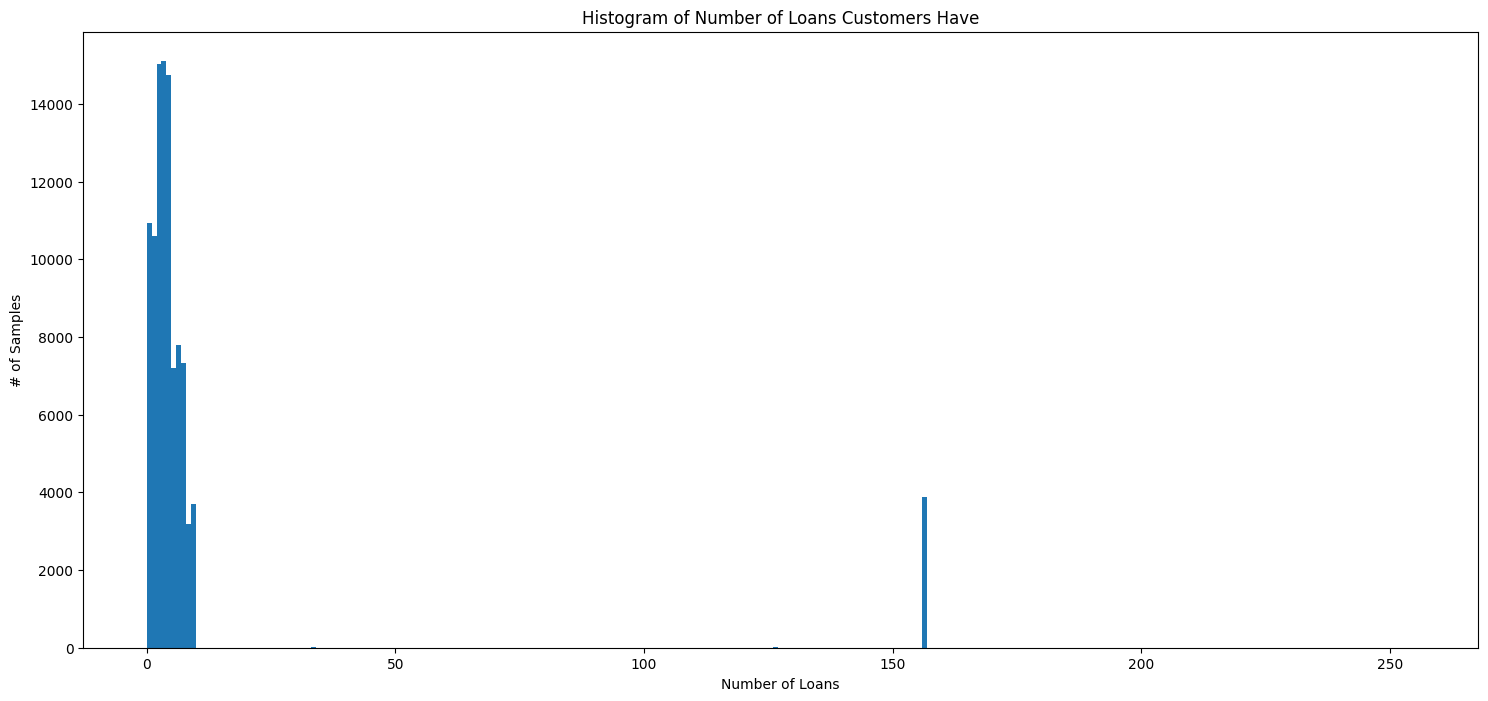

The number of loans each customer has ranges from 0 to 255.


In [17]:
histogram_visual(data['num_loans'],
                 num_of_bins=255,
                 plot_title="Histogram of Number of Loans Customers Have",
                 x_label="Number of Loans")

print(f"The number of loans each customer has " +
      f"ranges from {min(data['num_loans'])}" +
      f" to {max(data['num_loans'])}.")

#### Dataset Visualization: Delay From Due Date

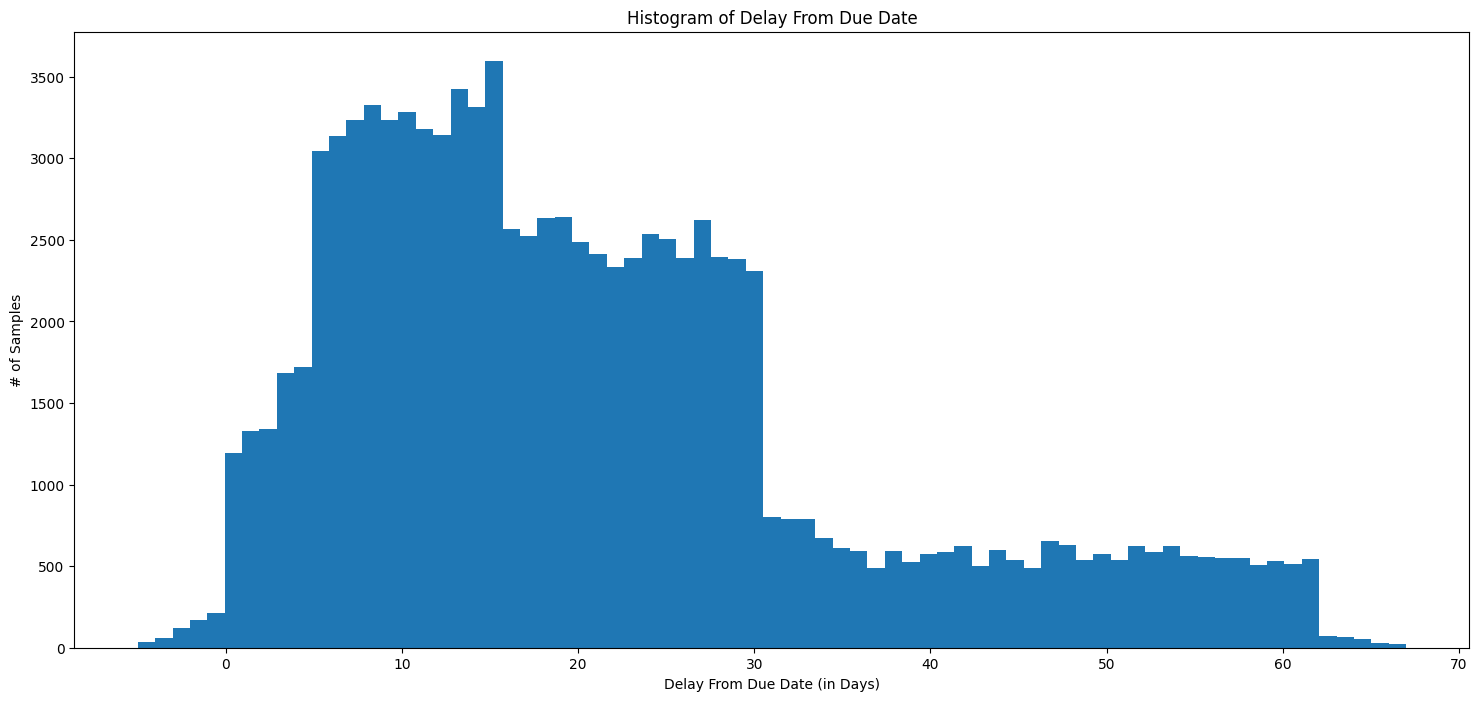

The delay from due date ranges from -5 to 67 days.


In [18]:
histogram_visual(data['delay_from_due_date'],
                 num_of_bins=73,
                 plot_title="Histogram of Delay From Due Date",
                 x_label="Delay From Due Date (in Days)")

print(f"The delay from due date ranges from " +
      f"{min(data['delay_from_due_date'])} to" +
      f" {max(data['delay_from_due_date'])} days.")

#### Dataset Visualization: Number of Delayed Payments

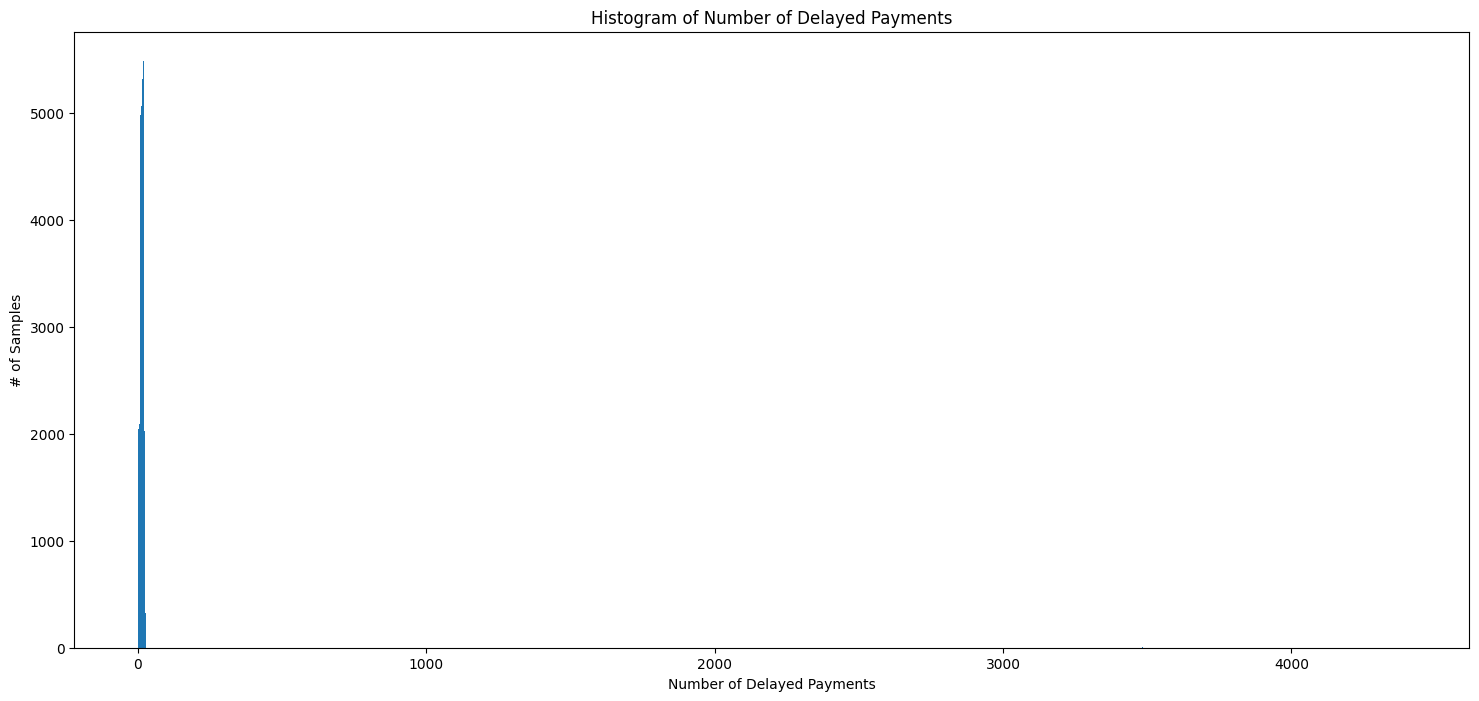

The Number of Delayed Payments ranges from 0.0 to 4397.0.


In [19]:
histogram_visual(data['num_delayed_payments'],
                 num_of_bins=4398,
                 plot_title="Histogram of Number of Delayed Payments",
                 x_label="Number of Delayed Payments")

print(f"The Number of Delayed Payments ranges from" +
      f" {min(data['num_delayed_payments'])} to" +
      f" {max(data['num_delayed_payments'])}.")

#### Dataset Visualization: Changed Credit Limit

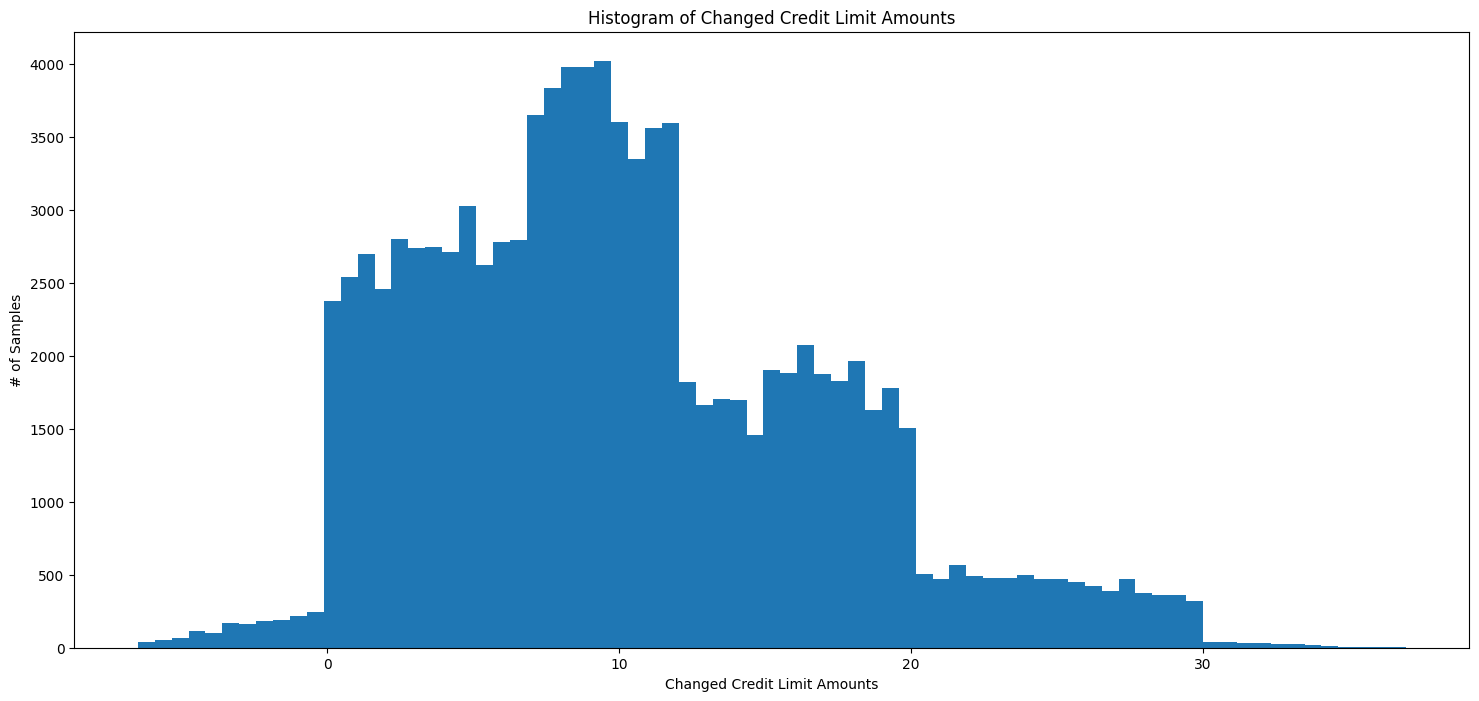

The percent change in credit limit ranges from -6.489999771118164% to 36.970001220703125%.


In [20]:
histogram_visual(data['changed_credit_limit'],
                 num_of_bins=75,
                 plot_title="Histogram of Changed Credit Limit Amounts",
                 x_label="Changed Credit Limit Amounts")

print(f"The percent change in credit limit ranges" +
      f" from {np.nanmin(data['changed_credit_limit'])}%" +
      f" to {np.nanmax(data['changed_credit_limit'])}%.")

#### Dataset Visualization: Number of Credit Inquiries

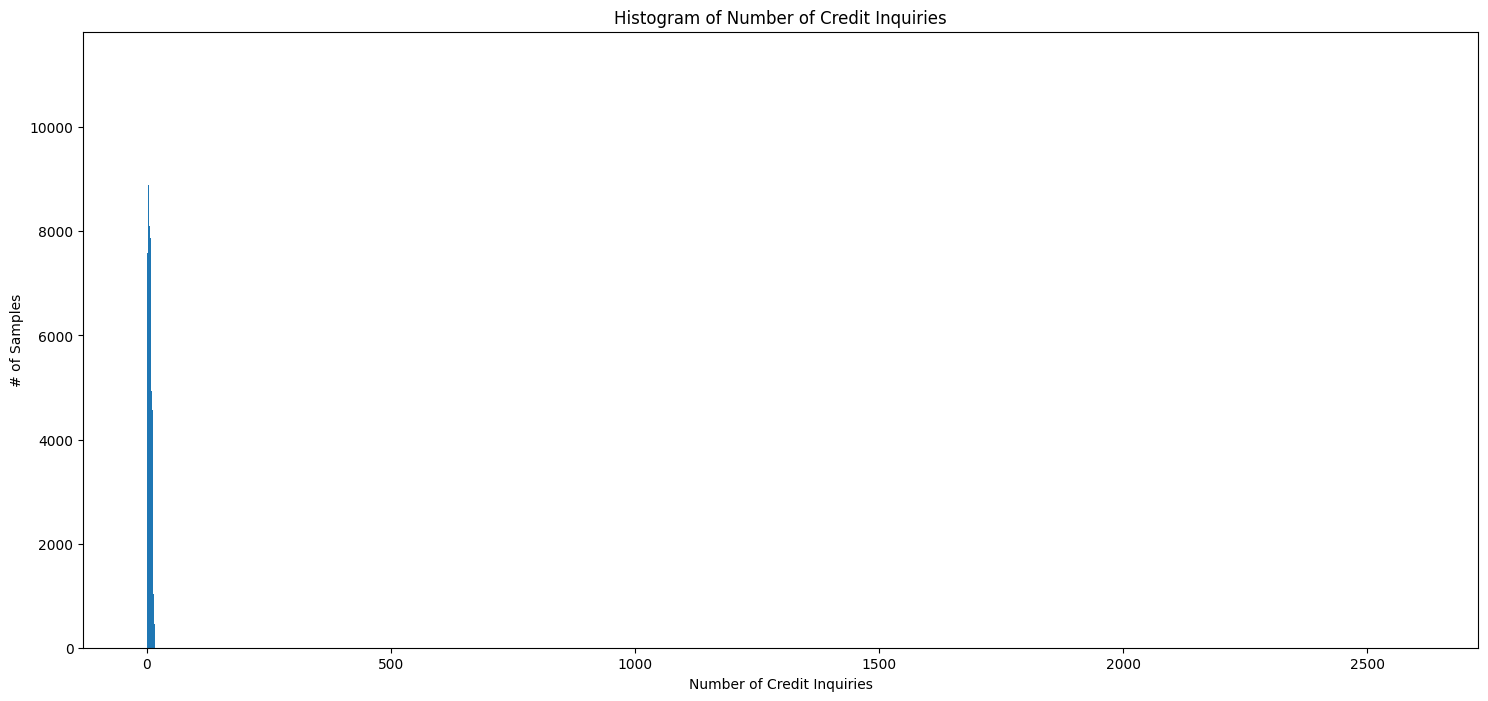

The number of credit inquiries ranges from 0.0 to 2597.0.


In [21]:
histogram_visual(data['num_credit_inquiries'],
                 num_of_bins=2598,
                 plot_title="Histogram of Number of Credit Inquiries",
                 x_label="Number of Credit Inquiries")

print(f"The number of credit inquiries ranges from" +
      f" {min(data['num_credit_inquiries'])} to" +
      f" {max(data['num_credit_inquiries'])}.")

#### Dataset Visualization: Outstanding Debt

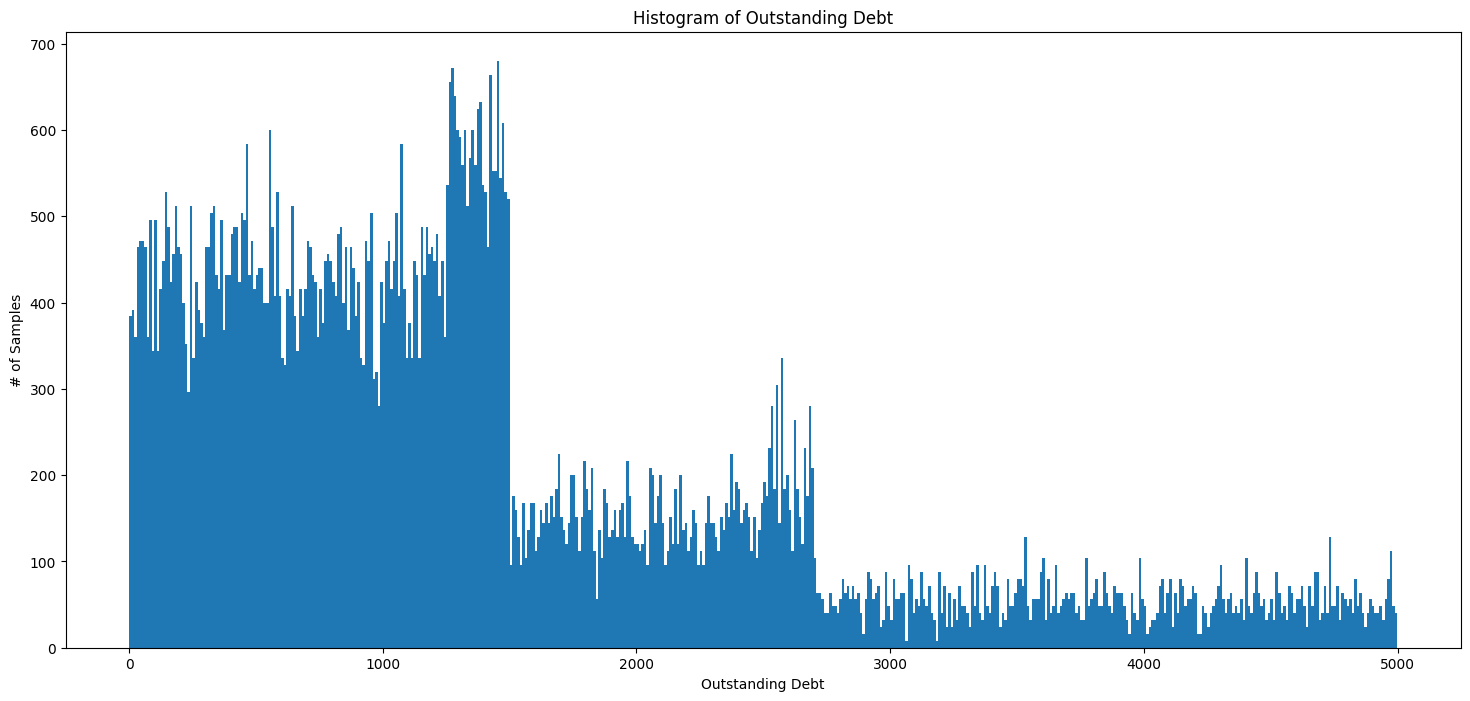

Outstanding debt ranges from $0.23 to $4998.07.


In [22]:
histogram_visual(data['outstanding_debt'],
                 num_of_bins=500,
                 plot_title="Histogram of Outstanding Debt",
                 x_label="Outstanding Debt")

print(f"Outstanding debt ranges from " +
      f"${round(min(data['outstanding_debt']), 2)} to" +
      f" ${round(max(data['outstanding_debt']), 2)}.")

#### Dataset Visualization: Credit Utilization Ratio

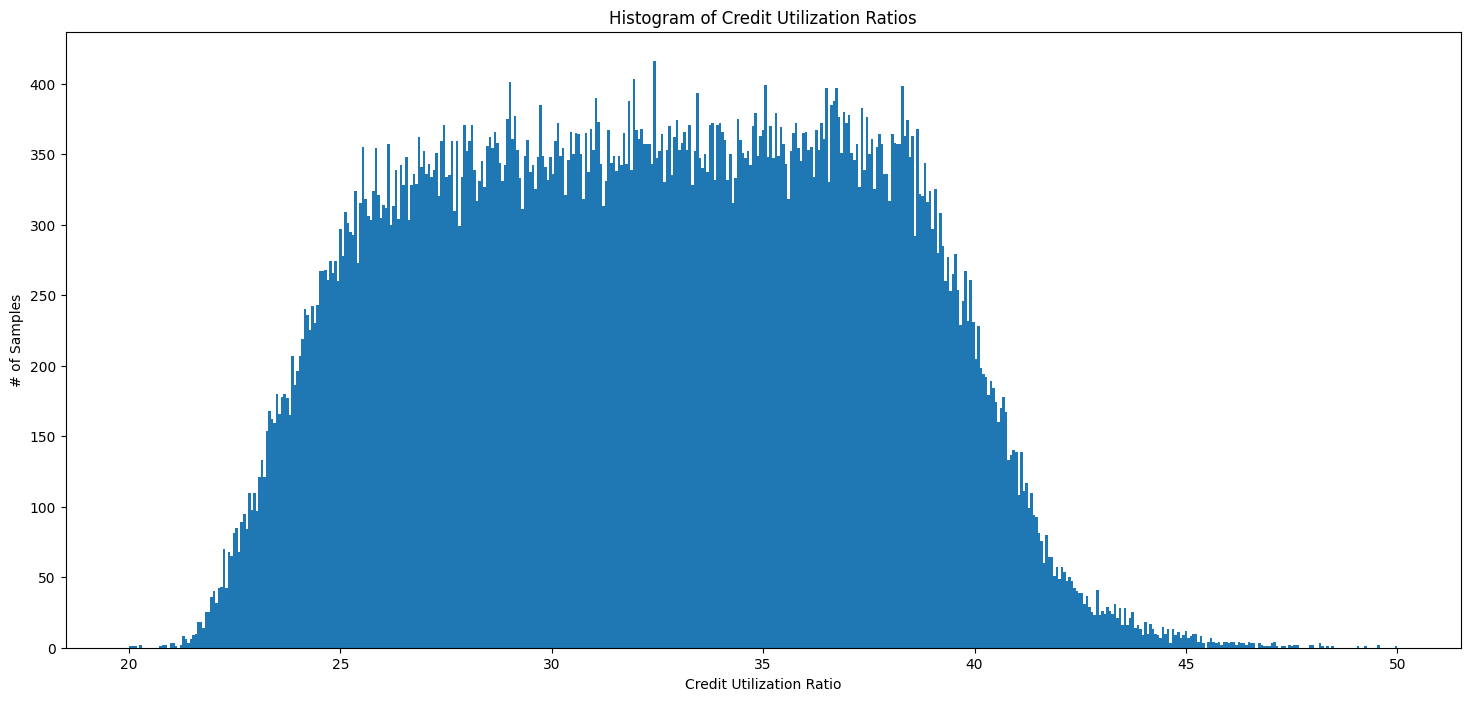

Credit Utilization Ratios range from 20.0 to 50.00000000000001.


In [23]:
histogram_visual(data['credit_util_ratio'],
                 num_of_bins=501,
                 plot_title="Histogram of Credit Utilization Ratios",
                 x_label="Credit Utilization Ratio")

print(f"Credit Utilization Ratios range from " +
      f"{min(data['credit_util_ratio'])} to" +
      f" {max(data['credit_util_ratio'])}.")

#### Dataset Visualization: Length of Credit History

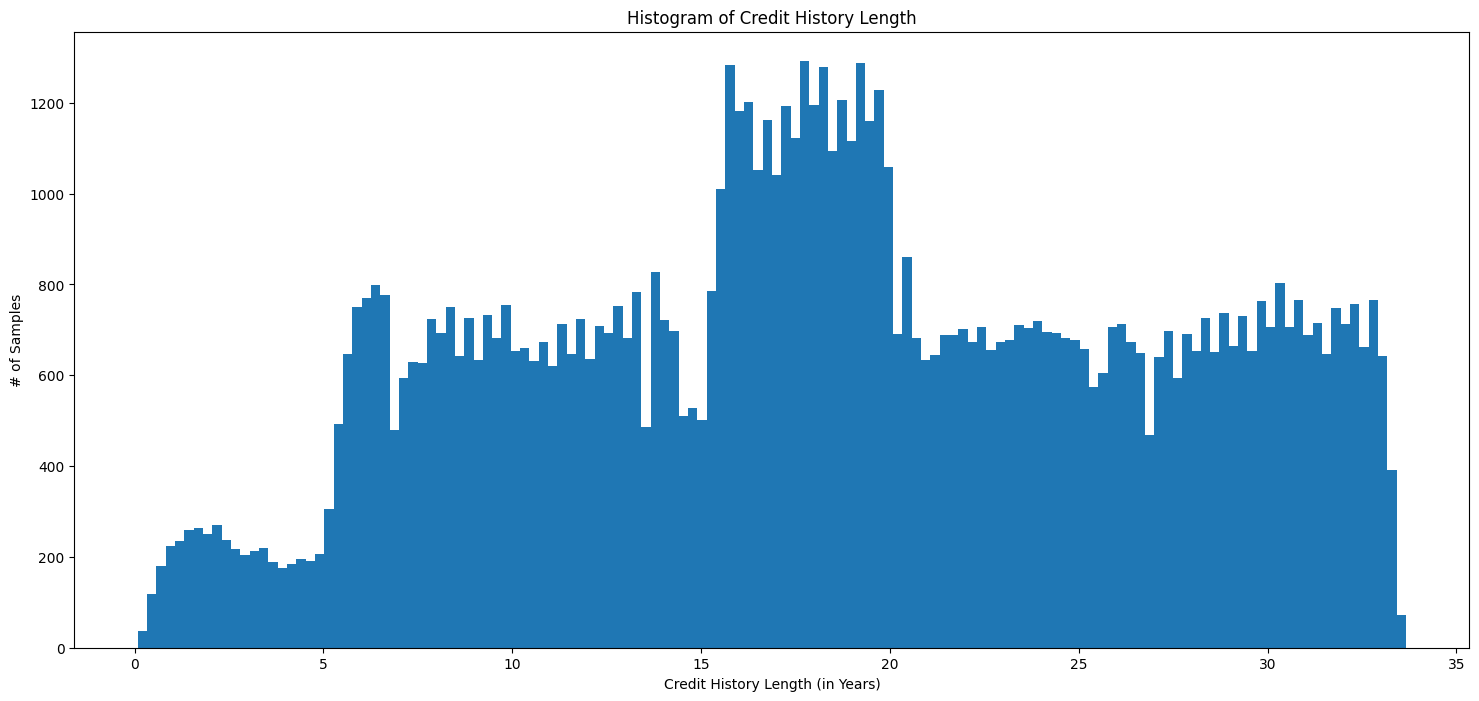

Credit score histories range from 0.08299999684095383 to 33.66699981689453.


In [24]:
histogram_visual(data['credit_history_length'],
                 num_of_bins=136,
                 plot_title="Histogram of Credit History Length",
                 x_label="Credit History Length (in Years)")

print(f"Credit score histories range from " +
      f"{min(data['credit_history_length'])} to" +
      f" {max(data['credit_history_length'])}.")

#### Dataset Visualization: Total EMI Per Month

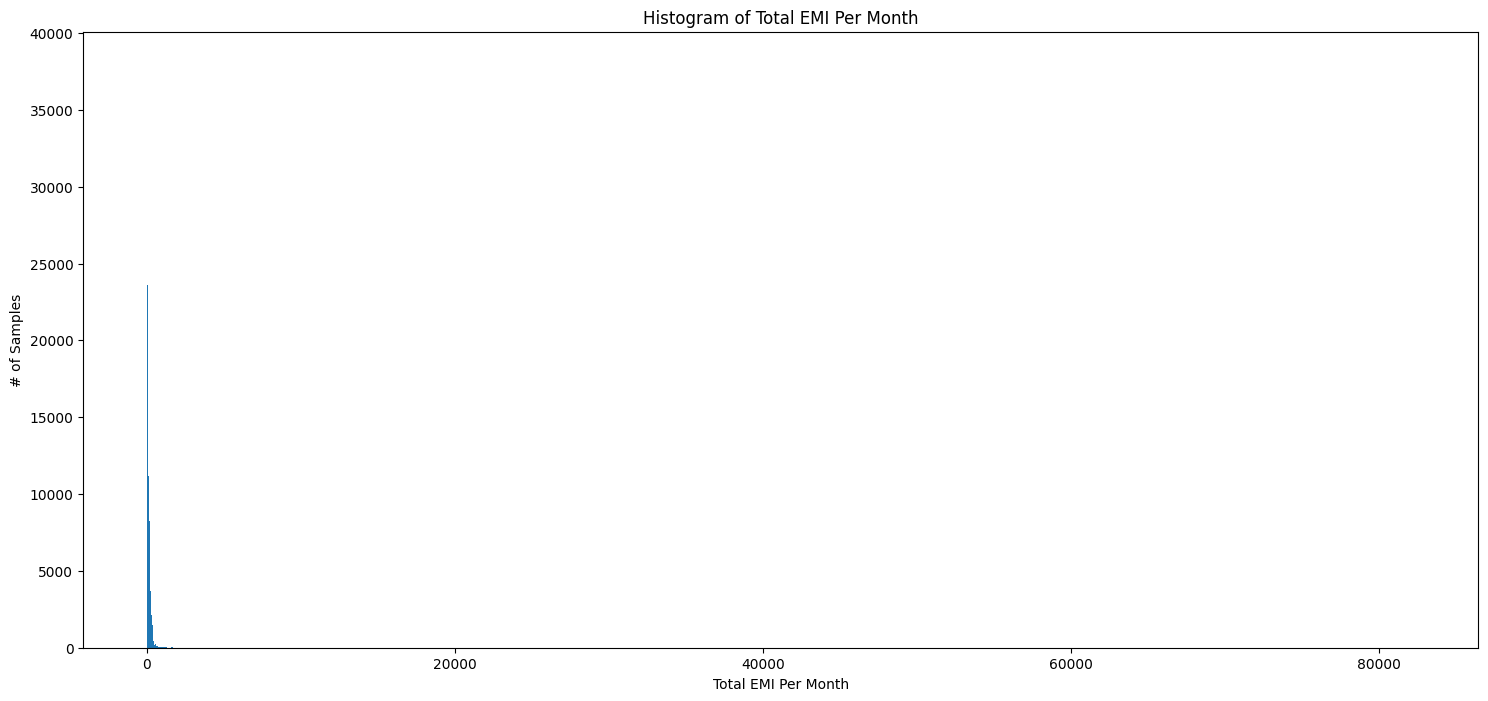

Total EMI per month ranges from 0.0 to 82331.0.


In [25]:
histogram_visual(data['total_emi_per_month'],
                 num_of_bins=1660,
                 plot_title="Histogram of Total EMI Per Month",
                 x_label="Total EMI Per Month")

print(f"Total EMI per month ranges from " +
      f"{min(data['total_emi_per_month'])} to" +
      f" {max(data['total_emi_per_month'])}.")

#### Dataset Visualization: Amount Invested Monthly

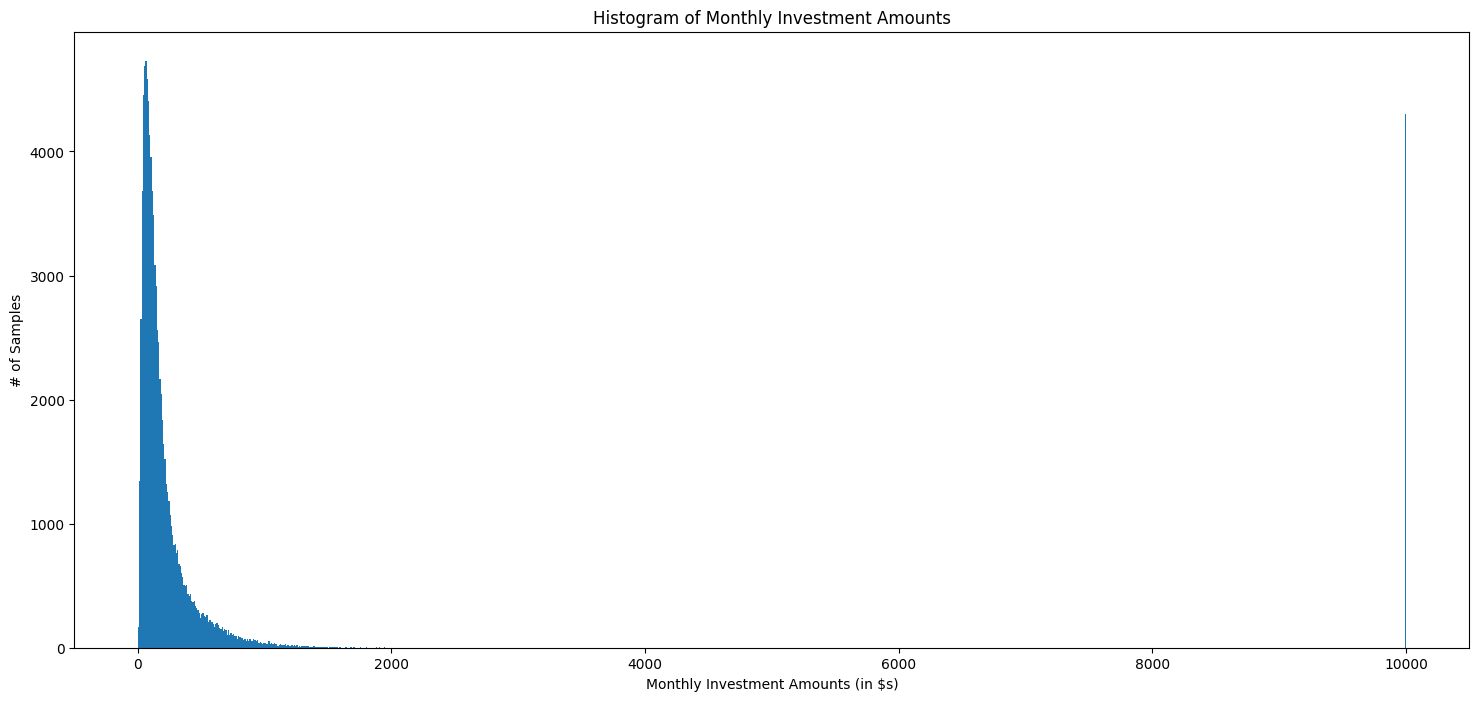

The amount that customers invested monthly ranges from $0.0 to $10000.0.


In [26]:
histogram_visual(data['amount_invested_monthly'],
                 num_of_bins=1000,
                 plot_title="Histogram of Monthly Investment Amounts",
                 x_label="Monthly Investment Amounts (in $s)")

print(f"The amount that customers invested monthly " +
      f"ranges from ${min(data['amount_invested_monthly'])}" +
      f" to ${max(data['amount_invested_monthly'])}.")

#### Create Function to Visualize Features (Barplot)

In [27]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   rotation: int = 0
                   ):
    """
    This function returns a histogram for a feature.

    Inputs:
    - feature_to_visualize: Feature to plot in the form
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.

    Output:
    - A Bar Plot.
    """

    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
    assert type(rotation) != np.uint8, \
        "The rotation angle must be a integer data type"

    ax = feature_to_visualize.value_counts().plot.bar(
                                                      figsize=(12,8),
                                                      rot=rotation,
                                                      legend=False,
                                                      color=["lightgreen",
                                                             "blue",
                                                             "brown",
                                                             "lightblue",
                                                             "tan",
                                                             "yellow",
                                                             "orange",
                                                             "green",
                                                             "red",
                                                             "purple"]
                                                      )

    ax.bar_label(ax.containers[0])

    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.show()

#### Dataset Visualization: Month

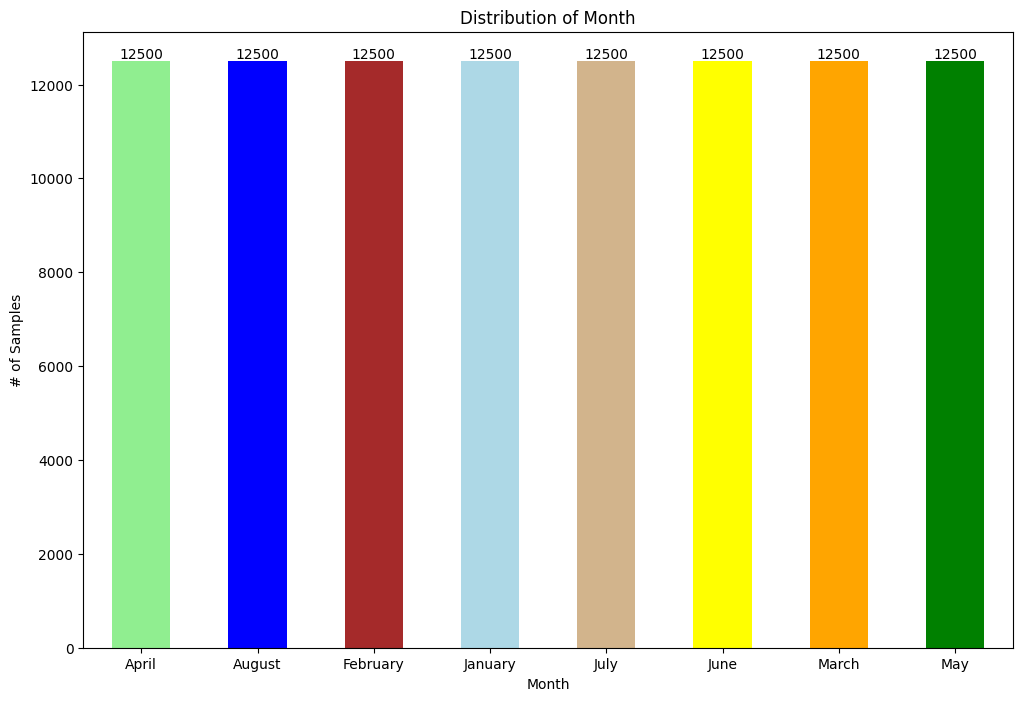

In [28]:
barplot_visual(data["month"],
               "Distribution of Month",
               "Month",
               "# of Samples",
               )

#### Dataset Visualization: Occupation

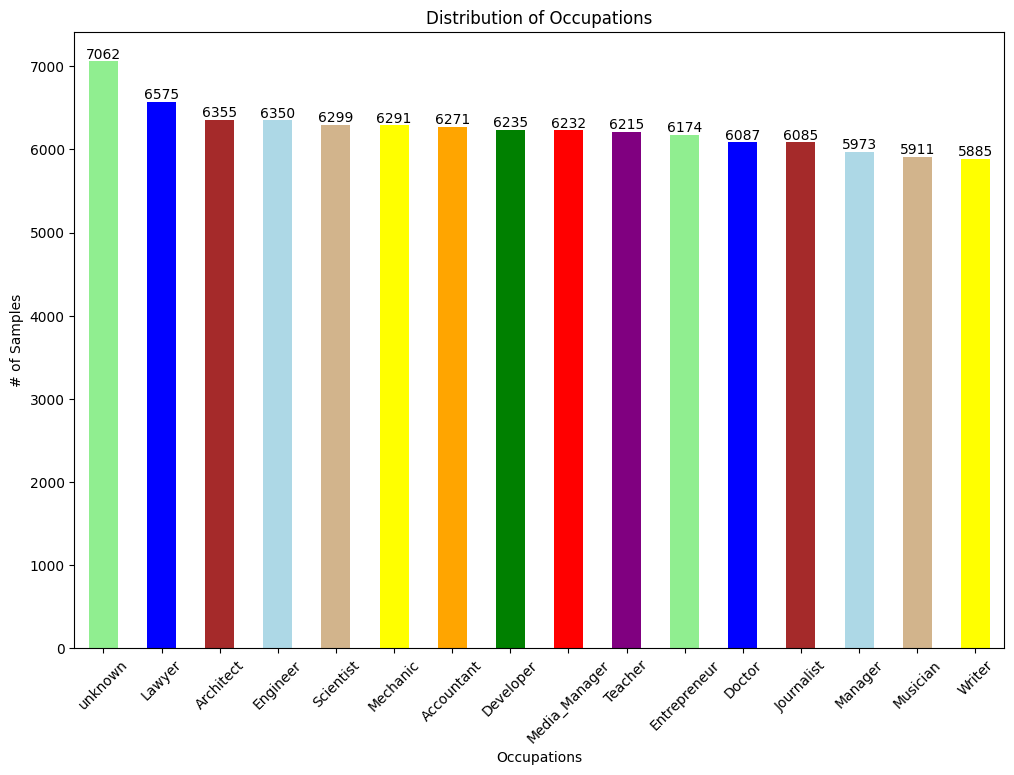

In [29]:
barplot_visual(data["occupation"],
               "Distribution of Occupations",
               "Occupations",
               "# of Samples",
               rotation=45
               )

#### Dataset Visualization: Credit Mix

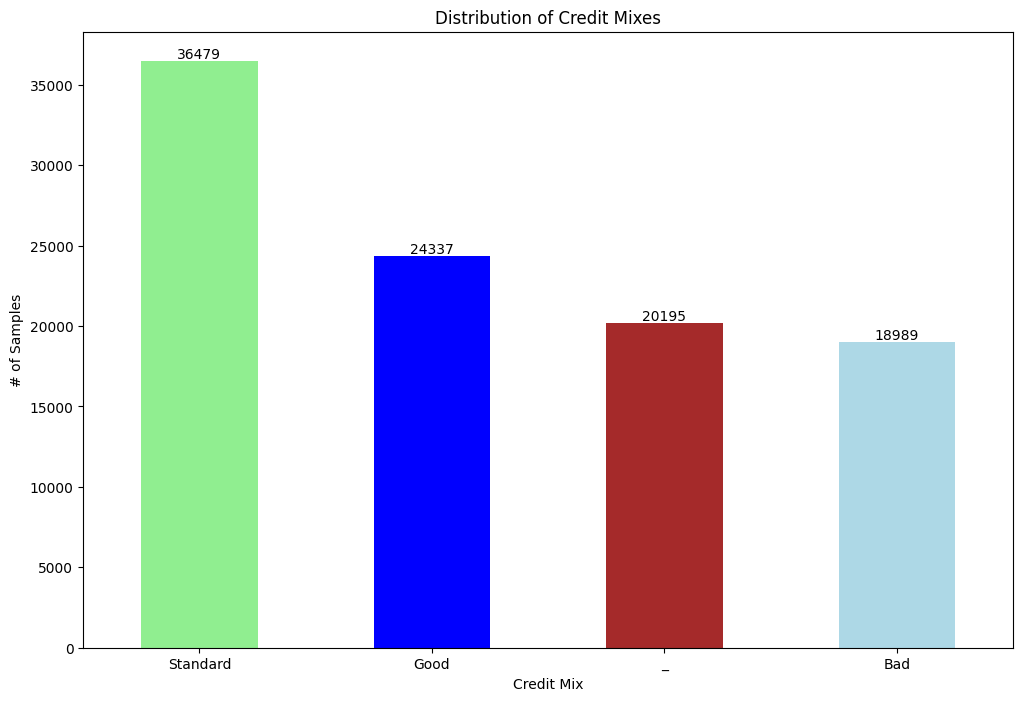

In [30]:
barplot_visual(data["credit_mix"],
               "Distribution of Credit Mixes",
               "Credit Mix",
               "# of Samples",
               )

#### Dataset Visualization: Payment Minimum Amount

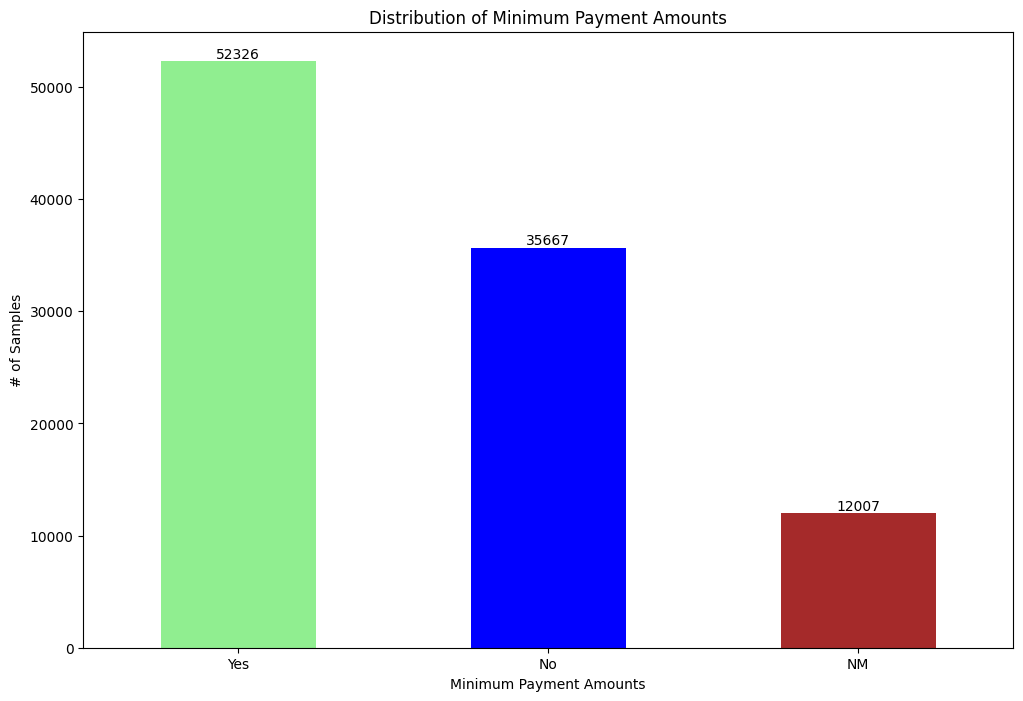

In [31]:
barplot_visual(data["payment_of_min_amount"],
               "Distribution of Minimum Payment Amounts",
               "Minimum Payment Amounts",
               "# of Samples",
               )

#### Dataset Visualization: Payment Behavior

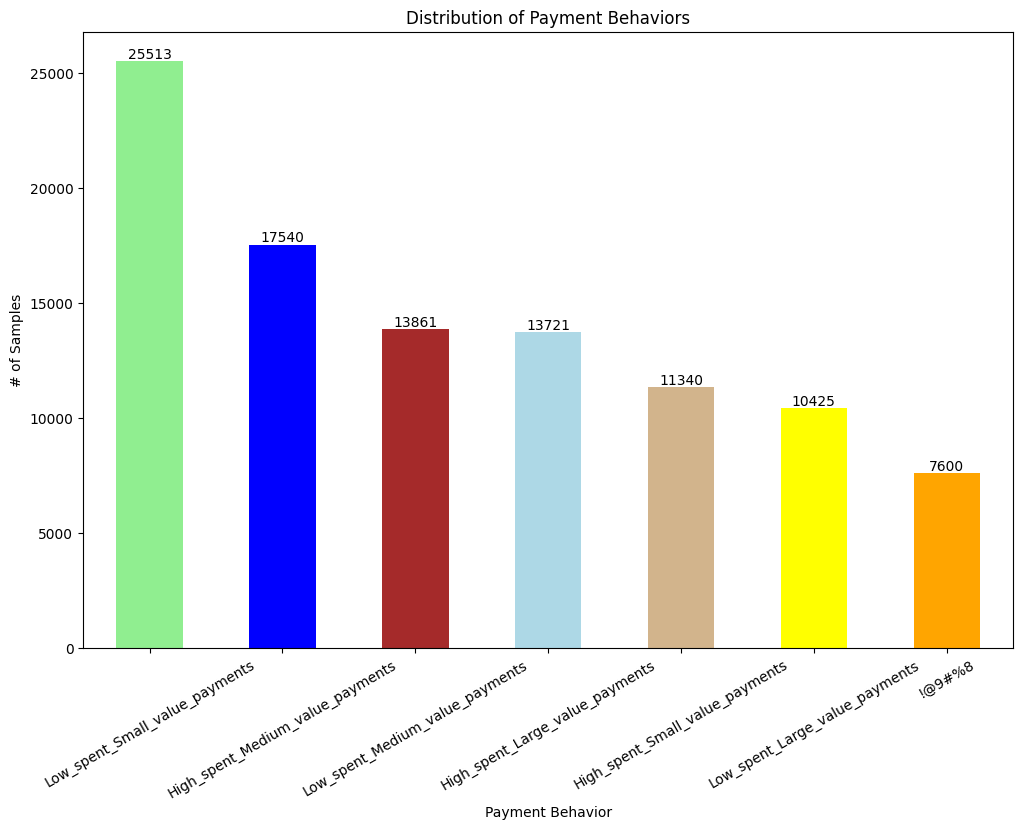

In [32]:
barplot_visual(data["payment_behaviour"],
               "Distribution of Payment Behaviors",
               "Payment Behavior",
               "# of Samples",
               rotation=30
               )

#### Dataset Visualization: Credit Score (Label)

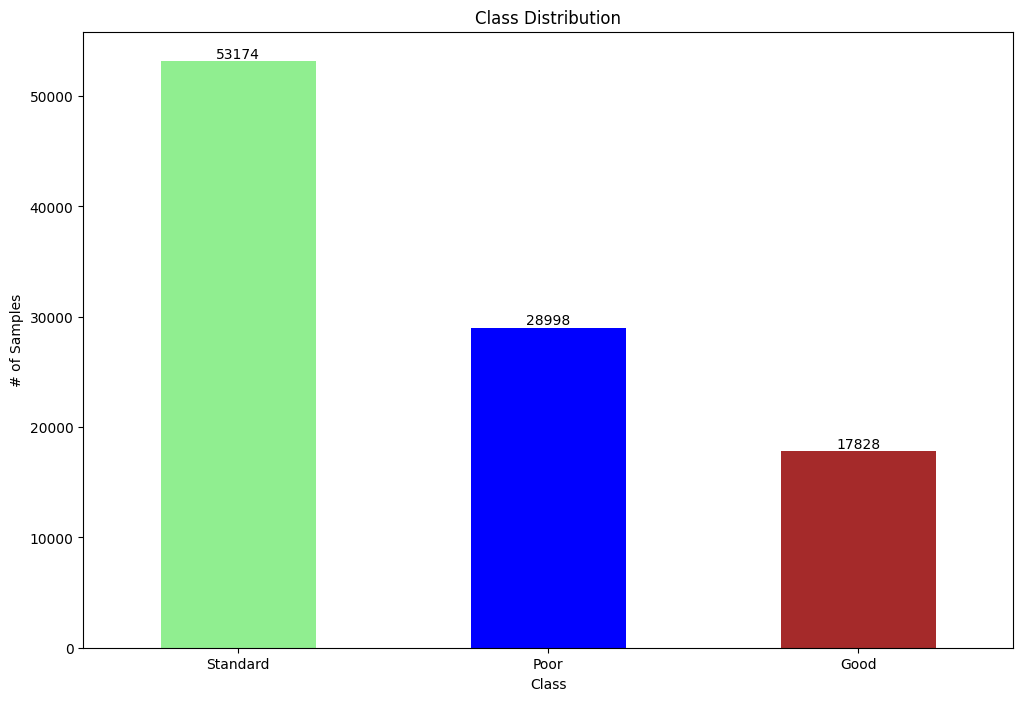

In [33]:
barplot_visual(data["label"],
               "Class Distribution",
               "Class",
               "# of Samples",
               )

### More Data Preprocessing

#### More Data Preprocessing (From Insight Gleaned From Visuals)

In [34]:
### Convert '!@9#%8' to 'unknown' for the 'payment_behavior' feature
data['payment_behaviour'] = data['payment_behaviour'].replace({'!@9#%8': 'unknown'})

### Change '-' to unknown for 'credit_mix' feature
data['credit_mix'] = data['credit_mix'].replace({'-': 'unknown'})

### handle instances of '__-333333333333333333333333333__' in 'monthly_balance' feature
data['monthly_balance'] = data['monthly_balance']\
    .replace({'__-333333333333333333333333333__': '-1'})\
    .astype(np.float32)

### Exploratory Data Analysis & Preprocessing

#### Correlation Matrix

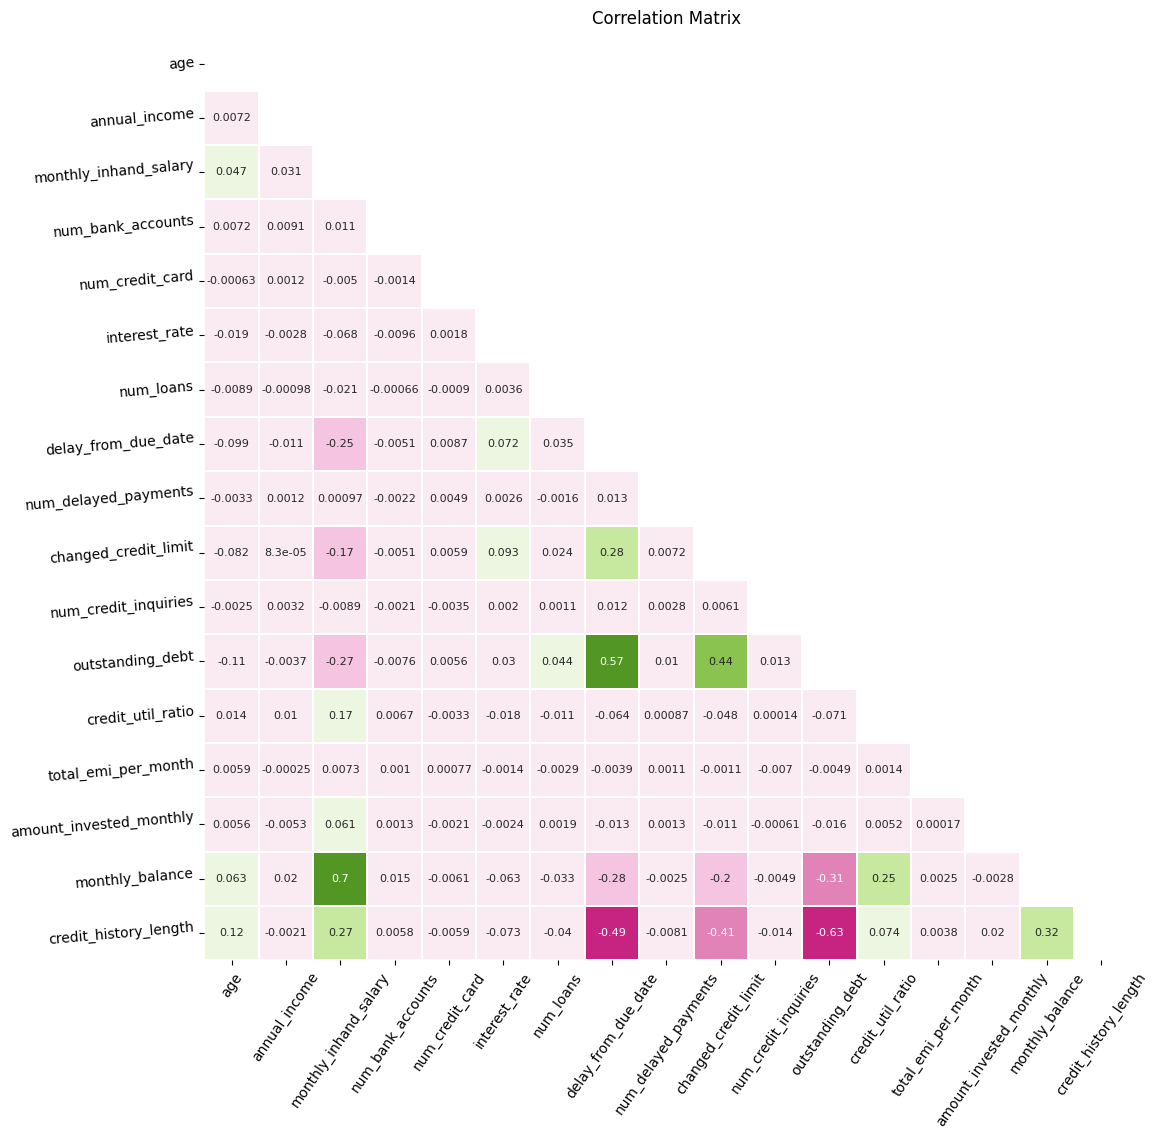

In [35]:
### only for numerical features and categorical features
### that are so far represented in numbers

corr_matrix_features = data.select_dtypes(exclude=["category", "object"]).columns

plt.figure(figsize=(12, 12))

lower_triangle = np.triu(data[corr_matrix_features].corr())

corr_matrix = sns.heatmap(data[corr_matrix_features].corr(),
                          annot=True,
                          cmap=sns.color_palette("PiYG", 8),
                          mask=lower_triangle,
                          square=True,
                          linewidths=0.25,
                          cbar=False,
                          annot_kws={"size": 8})

corr_matrix.set_title("Correlation Matrix",
                      pad=9)

corr_matrix.set_xticklabels(corr_matrix.get_xticklabels(),
                            rotation=55)

corr_matrix.set_yticklabels(corr_matrix.get_xticklabels(),
                            rotation=5)

plt.show()

#### Descriptive Statistics

In [36]:
data.describe(percentiles=
              [0.01,
               0.10,
               0.25,
               0.50,
               0.75,
               0.90,
               0.99
               ],
              include='all')

,month,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_loans,loan_type,...,credit_mix,outstanding_debt,credit_util_ratio,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,label,credit_history_length
count,100000,100000.000000,100000,1.000000e+05,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,88592,...,100000,100000.000000,100000.000000,100000,100000.000000,95521.000000,100000,98800.000000,100000,90970.000000
unique,8,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,6260,...,4,NaN,NaN,3,NaN,NaN,7,NaN,3,NaN
top,April,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,Not Specified,...,Standard,NaN,NaN,Yes,NaN,NaN,Low_spent_Small_value_payments,NaN,Standard,NaN
freq,12500,NaN,7062,NaN,NaN,NaN,NaN,NaN,NaN,1408,...,36479,NaN,NaN,52326,NaN,NaN,25513,NaN,53174,NaN
mean,NaN,34.860900,NaN,1.764157e+05,4194.170898,30.853840,22.47443,9.778597,10.026920,NaN,...,NaN,1426.220337,32.285173,NaN,1403.118217,637.412998,NaN,402.514496,NaN,18.432961
std,NaN,19.366472,NaN,1.429618e+06,3183.686279,956.581762,129.05741,7.028782,30.997598,NaN,...,NaN,1155.129028,5.116875,NaN,8306.041270,2043.319327,NaN,213.950424,NaN,8.311780
min,NaN,0.000000,NaN,7.005930e+03,303.645416,0.000000,0.00000,0.250000,0.000000,NaN,...,NaN,0.230000,20.000000,NaN,0.000000,0.000000,NaN,-1.000000,NaN,0.083000
1%,NaN,14.000000,NaN,7.535997e+03,531.875427,0.000000,1.00000,0.250000,0.000000,NaN,...,NaN,27.625599,22.740859,NaN,0.000000,16.832606,NaN,67.665085,NaN,1.417000
10%,NaN,19.000000,NaN,1.429334e+04,1105.052490,2.000000,3.00000,0.310000,0.000000,NaN,...,NaN,230.737004,25.345232,NaN,0.000000,43.961177,NaN,218.396332,NaN,7.000000
25%,NaN,24.000000,NaN,1.945750e+04,1625.568237,3.000000,4.00000,4.000000,2.000000,NaN,...,NaN,566.072510,28.052567,NaN,30.306660,74.534002,NaN,270.092224,NaN,12.000000


### Prepare Shared Pipeline Data & Stages/Steps

#### Split Dataset into Features & Label

In [37]:
y = data['label']
X = data.drop(columns=['label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(f"Training Input Dataset Shape: {X_train.shape}")
print(f"Training Output Dataset Shape: {y_train.shape}")

print(f"Evaluation Input Dataset Shape: {X_test.shape}")
print(f"Evaluation Output Dataset Shape: {y_test.shape}")

Training Input Dataset Shape: (75000, 23)
Training Output Dataset Shape: (75000,)
Evaluation Input Dataset Shape: (25000, 23)
Evaluation Output Dataset Shape: (25000,)


#### Metrics Evaluation Method

In [38]:
def metrics_evaluation(classifier_type,
                       y_test,
                       y_pred_cv):

    print("+-------------------------------------------------------------------------+")
    print("|  " + ("Confusion Matrix for " + classifier_type).center(69) + "  |")
    print("+-------------------------------------------------------------------------+")

    cm = confusion_matrix(y_test,
                          y_pred_cv)

    display_cm = ConfusionMatrixDisplay(cm)

    display_cm.plot()
    plt.show()

    print("+-----------------------------------------------------+")
    print("|  " + ("Classification Report for " + classifier_type).center(49) + "  |")
    print("+-----------------------------------------------------+")

    print(classification_report(y_test,
                                y_pred_cv,
                                zero_division=0
                                )
          )

### Auto-Sklearn Classifier

#### Define Pipeline/Model

In [39]:
as_clf_pipe = AutoSklearnClassifier()

#### Fit Auto-Sklearn Classifier to Dataset

In [40]:
as_clf_model = as_clf_pipe.fit(X_train,
                               y_train)

/usr/local/lib/python3.10/dist-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


#### Generate Predictions

In [43]:
predictions = as_clf_model.predict(X_test)

#### Metrics Evaluation

+-------------------------------------------------------------------------+
|               Confusion Matrix for Auto Sklearn Classifier              |
+-------------------------------------------------------------------------+


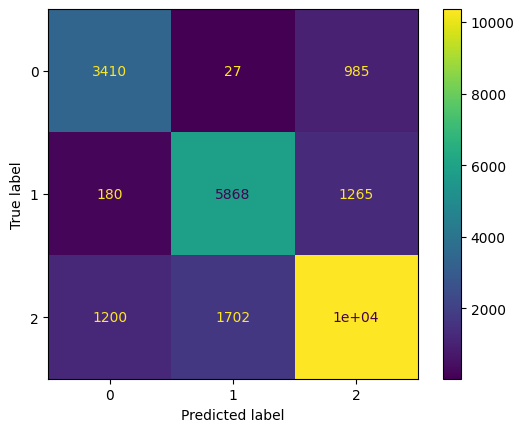

+-----------------------------------------------------+
|  Classification Report for Auto Sklearn Classifier  |
+-----------------------------------------------------+
              precision    recall  f1-score   support

        Good       0.71      0.77      0.74      4422
        Poor       0.77      0.80      0.79      7313
    Standard       0.82      0.78      0.80     13265

    accuracy                           0.79     25000
   macro avg       0.77      0.78      0.78     25000
weighted avg       0.79      0.79      0.79     25000



In [44]:
metrics_evaluation("Auto Sklearn Classifier",
                       y_test,
                       predictions)

### Notes & Other Takeaways From This Project
****
- Unfortunately, the results are not as good as I would like.

****

### Citations

- Auto-Sklearn
    > @inproceedings{feurer-neurips15a, title = {Efficient and Robust Automated Machine Learning}, author = {Feurer, Matthias and Klein, Aaron and Eggensperger, Katharina and Springenberg, Jost and Blum, Manuel and Hutter, Frank}, booktitle = {Advances in Neural Information Processing Systems 28 (2015)}, pages = {2962--2970}, year = {2015}}

    > @article{feurer-arxiv20a, title = {Auto-Sklearn 2.0: Hands-free AutoML via Meta-Learning}, author = {Feurer, Matthias and Eggensperger, Katharina and Falkner, Stefan and Lindauer, Marius and Hutter, Frank}, journal = {arXiv:2007.04074 [cs.LG]}, year = {2020},}